## Titanic EDA & Logistic Regression Analysis
*Author: Dimitrios Syntrivanis*  
*Goal: Exploration and modelization of survival outcomes using the Titanic dataset*

In [6]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Visualization settings
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

> *This cell imports necessary libraries for data processing (Pandas), visualization (Seaborn, Matplotlib), and modeling (Scikit-learn). We also customize Seaborn style and figure size for better visuals.*

In [8]:
# Load Titanic dataset
df = sns.load_dataset("titanic")

# Initial inspection
print(df.head())
print(df.isnull().sum())
print("Median Age:", df['age'].median())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck      

> *The dataset has missing values in `age`, `deck`, and `embark_town`. The median age is displayed for use in imputing missing age values.*

In [10]:
# Fill missing values
df['age'] = df['age'].fillna(df['age'].median())
df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])

# Drop features with too many missing values
df = df.drop(columns=['deck'])
df.dropna(inplace=True)

# Post-cleaning check
print(df.head())
print(df.isnull().sum())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male  embark_town alive  alone  
0    man        True  Southampton    no  False  
1  woman       False    Cherbourg   yes  False  
2  woman       False  Southampton   yes   True  
3  woman       False  Southampton   yes  False  
4    man        True  Southampton    no   True  
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int6

> *Missing values in `age` and `embark_town` are filled using median and mode respectively. The `deck` column is dropped due to excessive missing data. Final check shows no nulls remaining.*

In [42]:
df['family_size'] = df['sibsp'] + df['parch']
df['is_alone'] = (df['family_size'] == 0).astype(int)

> *New features are added: `family_size` (total relatives onboard) and `is_alone` (binary flag if traveling solo). These can be predictive of survival odds.*


In [14]:
# Encode categorical to numeric
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df['class'] = df['class'].map({'Third': 3, 'Second': 2, 'First': 1})

# Preview changes
print(df.head())

   survived  pclass  sex   age  sibsp  parch     fare  embarked class    who  \
0         0       3    0  22.0      1      0   7.2500         0     3    man   
1         1       1    1  38.0      1      0  71.2833         1     1  woman   
2         1       3    1  26.0      0      0   7.9250         0     3  woman   
3         1       1    1  35.0      1      0  53.1000         0     1  woman   
4         0       3    0  35.0      0      0   8.0500         0     3    man   

   adult_male  embark_town alive  alone  family_size  is_alone  
0        True  Southampton    no  False            1         0  
1       False    Cherbourg   yes  False            1         0  
2       False  Southampton   yes   True            0         1  
3       False  Southampton   yes  False            1         0  
4        True  Southampton    no   True            0         1  


> *Categorical variables (`sex`, `embarked`, `class`) are encoded numerically to be usable in machine learning models. Now all features are numeric.*

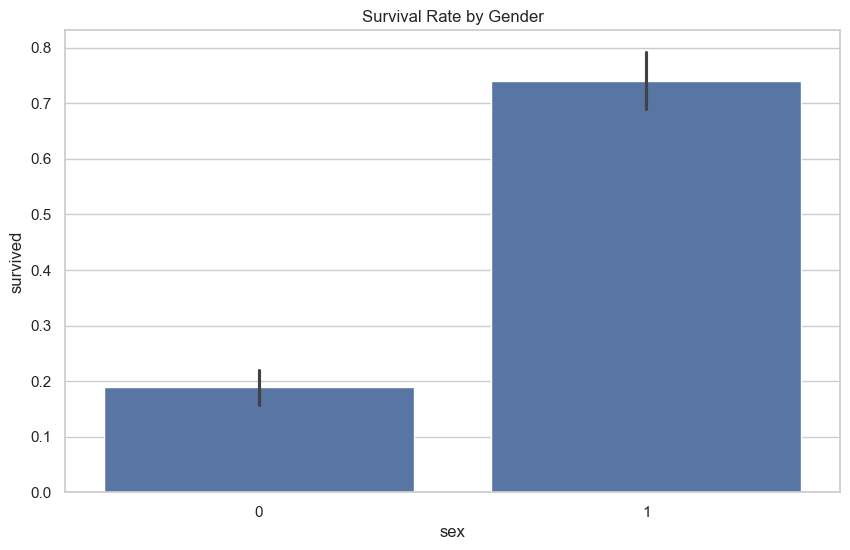

In [16]:
# Survival by gender
sns.barplot(x='sex', y='survived', data=df)
plt.title('Survival Rate by Gender')
plt.show()

> *Women had a significantly higher survival rate than men, confirming historical accounts of "women and children first."*

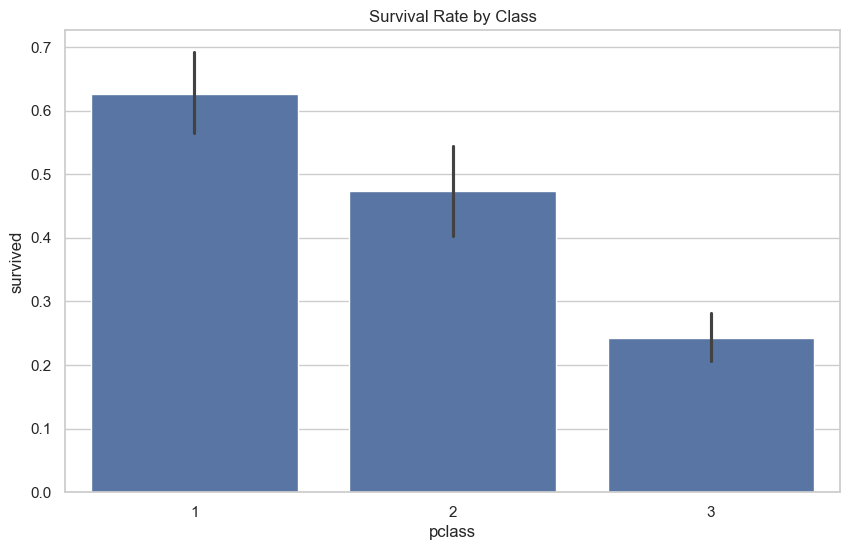

In [18]:
# Survival by class
sns.barplot(x='pclass', y='survived', data=df)
plt.title('Survival Rate by Class')
plt.show()

> *Lower Class passengers had lower chance of Survival.*

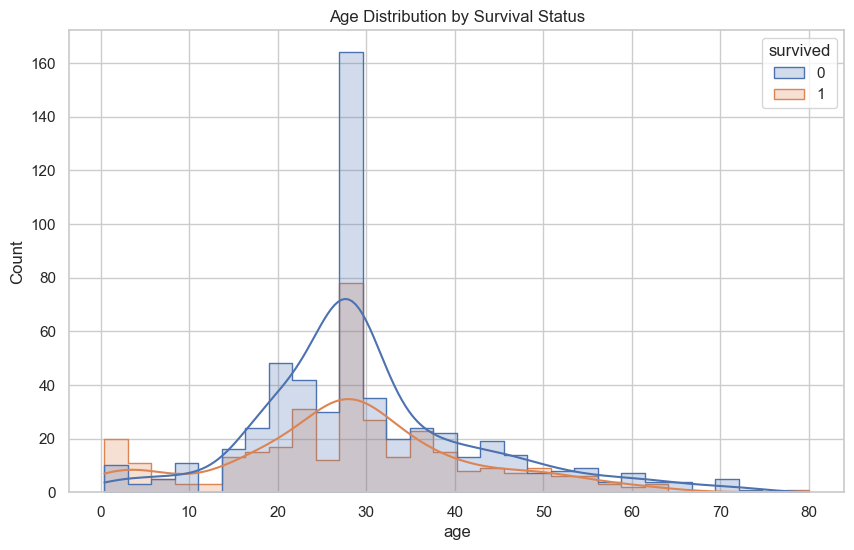

In [20]:
# Age distribution by survival
sns.histplot(data=df, x='age', hue='survived', kde=True, element='step')
plt.title('Age Distribution by Survival Status')
plt.show()

> *We see Survival jump above Mortality below the age of 10.*

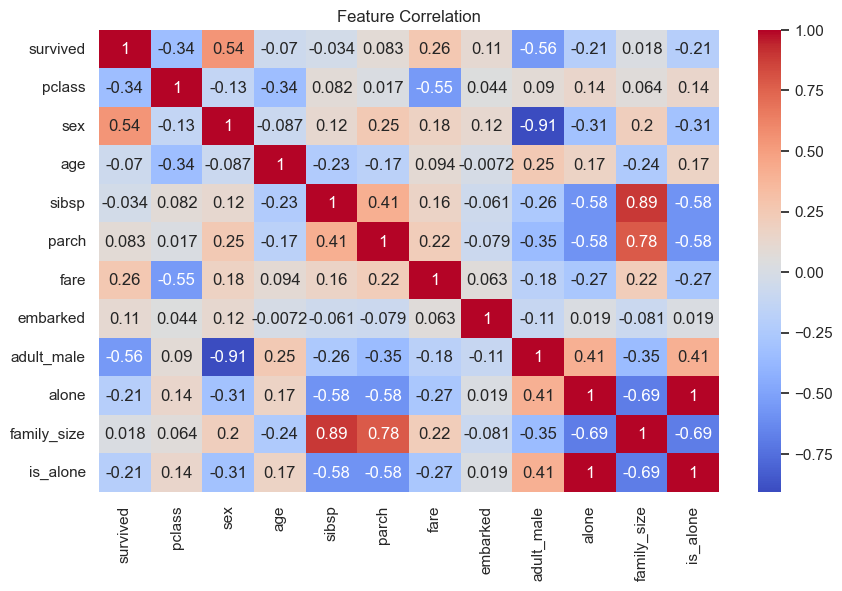

In [22]:
# Correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

> *There is a positive Correlation between Sex/Fare and Survival, and a negative correlation between Survival and Class.*

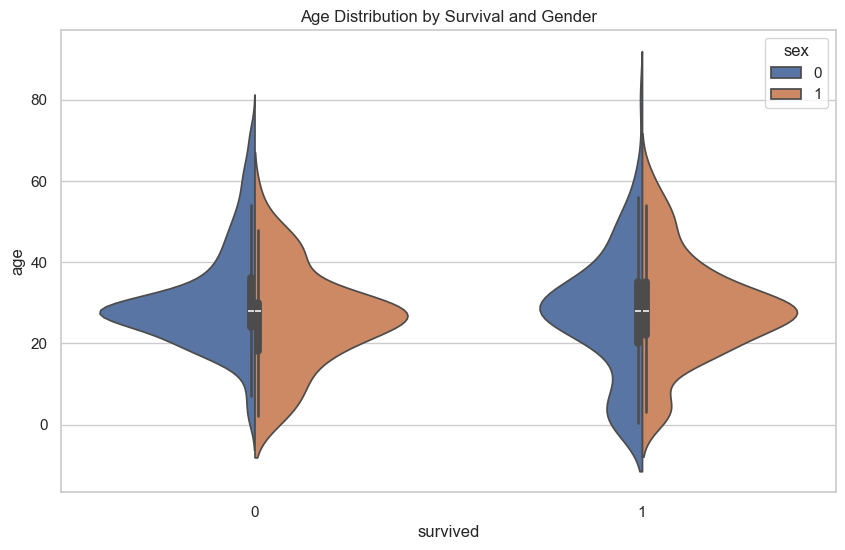

In [24]:
# Violin plot: Age, survival & gender
sns.violinplot(x='survived', y='age', hue='sex', data=df, split=True)
plt.title('Age Distribution by Survival and Gender')
plt.show()

> *Here again we see the effect that Sex has on the Survival Rate. We also see Survival Rate between men increase at lower Ages.*

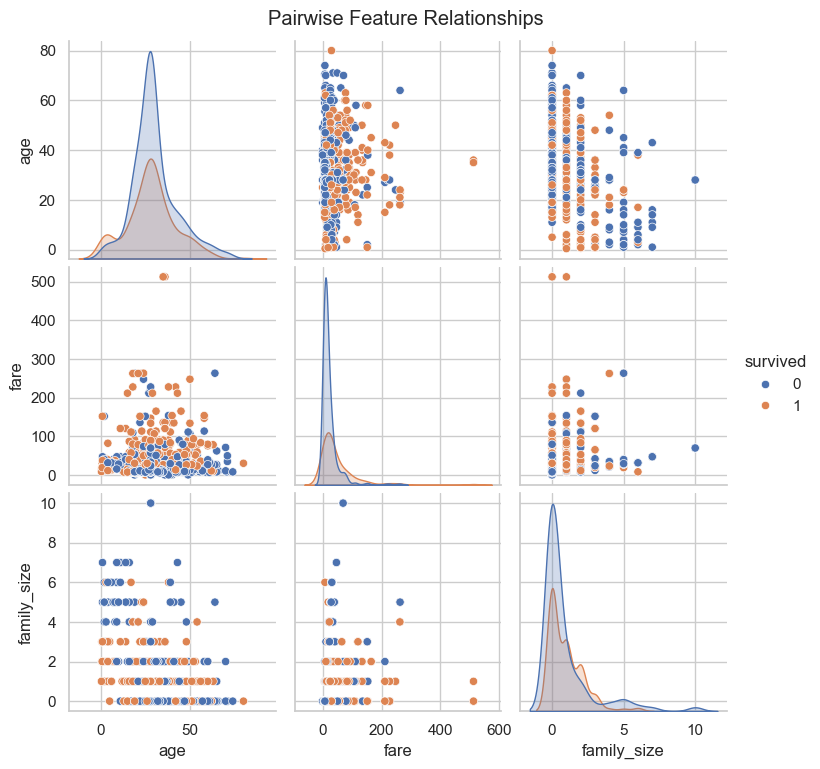

In [26]:
# Pairplot
sns.pairplot(df[['survived', 'age', 'fare', 'family_size']], hue='survived')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

In [28]:
# Feature selection
features = ['sex', 'age', 'fare', 'pclass', 'family_size', 'is_alone']
X = df[features]
y = df['survived']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       109
           1       0.74      0.78      0.76        69

    accuracy                           0.81       178
   macro avg       0.80      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



> *We select six features for our logistic regression model. The dataset is split into training and test sets (80/20 split). The classification report shows performance metrics such as precision, recall, and F1-score. Even with simple features, the model performs decently.*

In [30]:
# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coefficients)
print("Intercept:", model.intercept_)

       Feature  Coefficient
0          sex     2.623496
3       pclass    -1.039055
5     is_alone    -0.805952
4  family_size    -0.451503
1          age    -0.042464
2         fare     0.002438
Intercept: [2.94942096]


> *Coefficients indicate feature influence on survival probability. Positive coefficients increase odds of survival. `sex`, `fare`, and `pclass` stand out.*

In [32]:
# Predictions on test set
print("Predictions:", model.predict(X_test))
print("Probabilities (first 5):")
print(model.predict_proba(X_test)[:5])

Predictions: [0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1
 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0
 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1
 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1]
Probabilities (first 5):
[[0.89506297 0.10493703]
 [0.0532829  0.9467171 ]
 [0.1919854  0.8080146 ]
 [0.7643831  0.2356169 ]
 [0.04475895 0.95524105]]


> *Here we see the predicted classes and survival probabilities for the first 5 passengers in the test set.*

In [34]:
# Hypothetical new passenger
new_passenger = pd.DataFrame([{
    'sex': 1,            # female
    'age': 28,
    'fare': 100,
    'pclass': 1,
    'family_size': 0,
    'is_alone': 1
}])

prediction = model.predict(new_passenger)
probability = model.predict_proba(new_passenger)

print("Prediction (0=did not survive, 1=survived):", prediction[0])
print("Survival probability:", probability[0][1])

Prediction (0=did not survive, 1=survived): 1
Survival probability: 0.9417336306234109


> *Our hypothetical passenger is a young woman in first class, traveling alone. The model predicts a high probability of survival.*

## Key Insights

- **Family size matters**: Solo travelers had lower odds of survival.
- **Fare and class** were strong indicators of survival (first class = higher chance).
- **Gender** was one of the most powerful predictors (females much more likely to survive).
- The basic logistic regression model showed surprisingly strong predictive power with just a few features.

---

## Model Summary

This model illustrates how even simple, interpretable features can predict survival with decent accuracy. It sets the foundation for more advanced modeling later.